## Asset Pricing HW2

#### Brian Wickman
#### October 2025

In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt

### 1. Consider the approximiation error for the linear approximation of investor marginal utility

Consider an investor with constant relative risk aversion with relative risk aversion $\gamma = 2$ and initial wealth $W_0 =1$. Plot the CRRA utility function for $W\in [0.3, 2]$.
    \begin{align*}
        U(W) &= \frac{W^{1-\gamma}}{1-\gamma} \text{ if } \gamma \neq 1, \quad \text{else} \quad U(W) = \log W\\
        U^{\prime}(W) &= W^{-\gamma}
    \end{align*}
   
On the same plot, draw the linear approx for marginal utility, assuming $\mathbb{E}[R_w] \approx 1, R_w = \frac{W}{W_0} = W$:
    $$\frac{U^{\prime}(W)}{U^{\prime}(\mathbb{E}[W])} \approx 1 - \gamma(R_w - \mathbb{E}[R_w]) \approx 1 - \gamma(W - 1)$$
    
As expected, the linear approximation for marginal utility only works for small changes in wealth, which makes sense since it is derived using the Taylor expansion. The linear approximation ignores higher order terms and systematically underestimating the marginal utility, substantially so for large decreases in wealth.

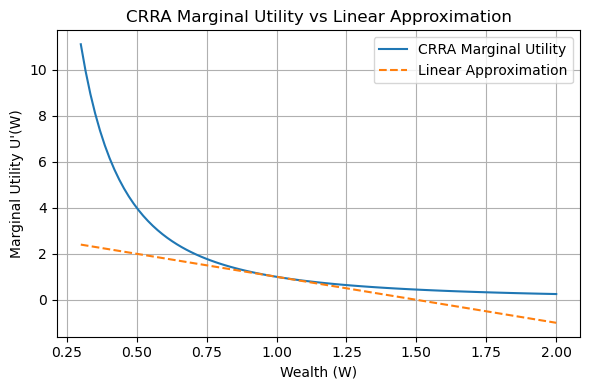

In [2]:
# Parameters
W = np.linspace(0.3, 2, 100)
gamma = 2  # example value for risk aversion
W_mean = 1.0

# Marginal Utility for CRRA
def U_prime(W, gamma):
   return W**(-1 * gamma)

# Linear approximation of marginal utility 
def U_prime_linear(W, gamma):
   return 1 - gamma*(W-1)

# Plot
plt.figure(figsize=(6,4))
plt.plot(W, U_prime(W, gamma), label='CRRA Marginal Utility')
plt.plot(W, U_prime_linear(W, gamma), '--', label='Linear Approximation')
plt.xlabel('Wealth (W)')
plt.ylabel("Marginal Utility U'(W)")
plt.title('CRRA Marginal Utility vs Linear Approximation')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


### 2a. Optimal portfolio share

Consider the CRRA investor's portfolio problem. Define risk-free rate $R_f = 1.2$ and risky asset returns $\log(R) \sim N(\mu, \sigma^2)$ with $\mu = 0.1, \sigma^2 = 0.36$. Calculate the optimal portfolio share using formula (1.11) based on the linear approximation of marginal utility.
   $$\omega = \frac{\mathbb{E}[R - R_f]}{\gamma \text{var}(R)}$$

Note that the risky asset returns are log-normally distributed, implying the following moments for the returns:
   \begin{align*}
      \mathbb{E}[R] &= \exp\left(\mu + \frac{\sigma^2}{2} \right)\\
       &= \exp(0.1 + 0.36/2) \approx 1.323\\
      \text{Var}[R] &= [\exp(\sigma^2) - 1]\exp(2\mu + \sigma^2) \\
      &= (\exp(0.36) - 1)(\exp(0.2 + 0.36)) \approx 0.759
   \end{align*}

In [3]:
# Calculate moments
mu_R = np.exp(0.28)
var_R = (np.exp(0.36) - 1) * (np.exp(0.56))
print(f'Risky returns distributed normally with mean {mu_R:.4f} and variance {var_R:.4f}')

# Calculate optimal portfolio share
R_f, gamma = 1.02, 2
port_share_analytic = (mu_R - R_f)/ (gamma * var_R)
print(f'Optimal portfolio share to risky asset: {port_share_analytic:.2%}')

Risky returns distributed normally with mean 1.3231 and variance 0.7586
Optimal portfolio share to risky asset: 19.98%


### 2b. Numerical solution for optimal portfolio share

Evaluate investor's expected utility via Monte Carlo integration over a grid of values from -1 to 2:
   $$\mathbb{E}[U(W)] \approx \frac{1}{N}\sum_{i=1}^N U(W_i)$$
where $W_i$ depends on the probability distribution of the risky asset return (1.6):
   $$W_i = \omega R_i + (1 - \omega)R_f, \quad R_i \sim N(1.323, 0.7586)$$
 Note that investors have limited liability, so wealth has a lower bound at zero. My first observation is that $\gamma = 2$ creates a strictly negative utility function.
    $$U(W) = \frac{-1}{W}$$

Also note that the utility function will be undefined at $W = 0$, so we need to handle that case in the code. I choose to set a lower bound on wealth at $1e-8$ to avoid undefined values. When we calculate the expected utility via Monte Carlo Integration (i.e. averaging $U(W)$), the average is dominated by the low wealth outcomes, which have very large negative utility.

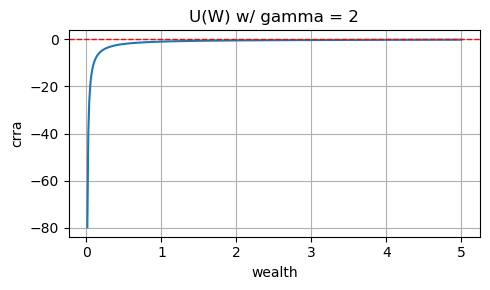

In [4]:
# Plot the CRRA utility function with gamma = 2
x = np.linspace(0, 5, 400); x = x[x != 0]  # Remove zero to avoid division by zero
y = -1 / x

plt.figure(figsize=(5,3))
plt.plot(x, y)
plt.axhline(0, color='r', linestyle='dashed', linewidth=1)
plt.xlabel('wealth'); plt.ylabel('crra'); plt.title('U(W) w/ gamma = 2')
plt.grid(True); plt.tight_layout(); plt.show()

I plot the distribution of wealth and utility for select portfolio shares to illustrate how the distribution of wealth changes with portfolio choice. First, I define the CRRA utility function and the Monte Carlo integration function to estimate expected utility for a given portfolio share.

In [5]:
# CRRA relative utility function
# how to handle low levels of wealth, especially 0
def crra_utility(w, gamma):
    if gamma == 1:
        return np.log(w)  # avoid log(0)
    else:
        util_vec = w ** (1 - gamma) / (1 - gamma)
        #return  np.where(util_vec < -50, 0, util_vec)
        return util_vec
    
# Estimate expected utility via Monte Carlo integration
gamma = 2 # crra relative risk aversion
def MonteCarlo_int(omega, N, ret_distributions = False):
   # Draw N risky asset returns
   R_risky = np.random.normal(loc = mu_R, scale = np.sqrt(var_R), size = N) # standard dev, not variance
   wealth = omega * R_risky + (1-omega) * R_f
   wealth = np.clip(wealth, 1e-8, None) # avoid 0 or negative wealth
   
   # check distributions in MC simulation
   util_distribution = crra_utility(wealth, gamma)
   if ret_distributions:
       return wealth, util_distribution, np.mean(util_distribution)
   return np.mean(util_distribution) # average utility of wealth

Based on the specified return distribution, let's analyze the distribution of wealth draws for different portfolio shares. Note the lower bound on wealth at 0 due to limited liability.
1. ($\omega = -1$) Short the risky asset and invest twice as much in the risk-free asset. The risk-free asset returns 2 * 1.02 = 2.04, which is wiped out if the risky asset return is greater than 2.04, which happens non-trivially often.
$$\mathbb{P}(R > 2.04) = 1 - \Phi\left(\frac{2.04 - 1.32}{0.7856}\right) \approx 17.9\%$$
2. ($\omega = 0$) Invest all wealth in the risk-free asset, which returns a guaranteed 1.02, with zero probability of wipeout.
3. ($\omega = 1$) Invest all wealth in the risky asset, which has a mean return of 1.32 and a standard deviation of 0.786, so there is a non-trivial chance of losing all wealth.
$$\mathbb{P}(R < 0) = \Phi\left(\frac{0 - 1.32}{0.7856}\right) \approx 4.65\%$$
4. ($\omega = 2$) Lever up and invest twice as much in the risky asset. This creates a substantial chance of losing all wealth.
$$\mathbb{P}(2R < 0) = \Phi\left(\frac{0 - 0.66}{0.7856}\right) \approx 20.0\%$$

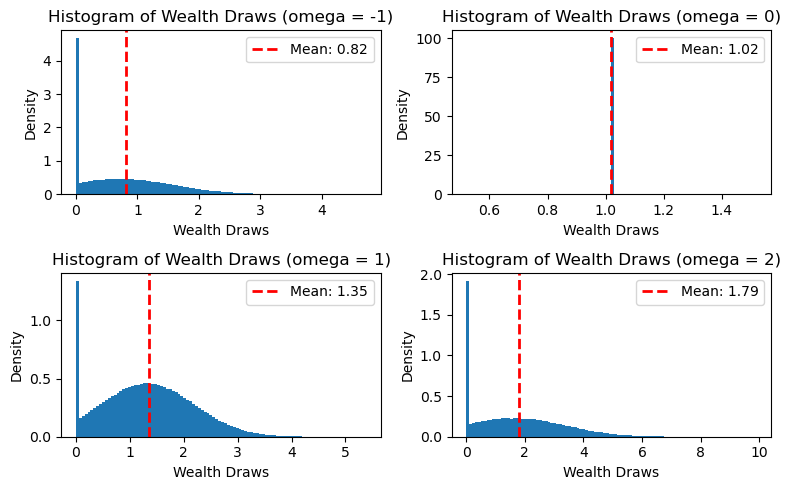

In [6]:
# Show wealth distribution as function of portfolio share
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 5))
axes_list = axes.flatten()

# Loop over omega values and corresponding subplot axes
for i, tmp_omega in enumerate([-1, 0, 1, 2]):
    # Calculate wealth distributions
    wealth_dist, util_dist, mc_results = MonteCarlo_int(
        omega=tmp_omega, N=int(1e6), ret_distributions=True
    )

    # Plot histogram on the corresponding subplot
    ax = axes_list[i]
    ax.hist(wealth_dist, bins=100, density=True)
    mean_wealth = np.mean(wealth_dist)
    ax.axvline(mean_wealth, color='r', linestyle='dashed', linewidth=2,
               label=f'Mean: {mean_wealth:.2f}')
    ax.set_xlabel('Wealth Draws')
    ax.set_ylabel('Density')
    ax.set_title(f'Histogram of Wealth Draws (omega = {tmp_omega})')
    ax.legend()

plt.tight_layout()
plt.show()

Since we know that the utility function evaluated at zero wealth produces infinite negative utility, the optimal portfolio share will be around zero. A portfolio share that has even a slight chance of wipeout will have an expectation dominated by these large negative utility outcomes (via Monte Carlo integration). Let's look at the distribution of utility draws for a select few portfolio shares that might be optimal.

As expected, a portfolio share as small as 0.3 introduces (at least) one wipeout in 100,000 draws, which creates a large negative utility draw that dominates the expected utility calculation. It appears that the optimal portfolio share will be slightly higher than 0.

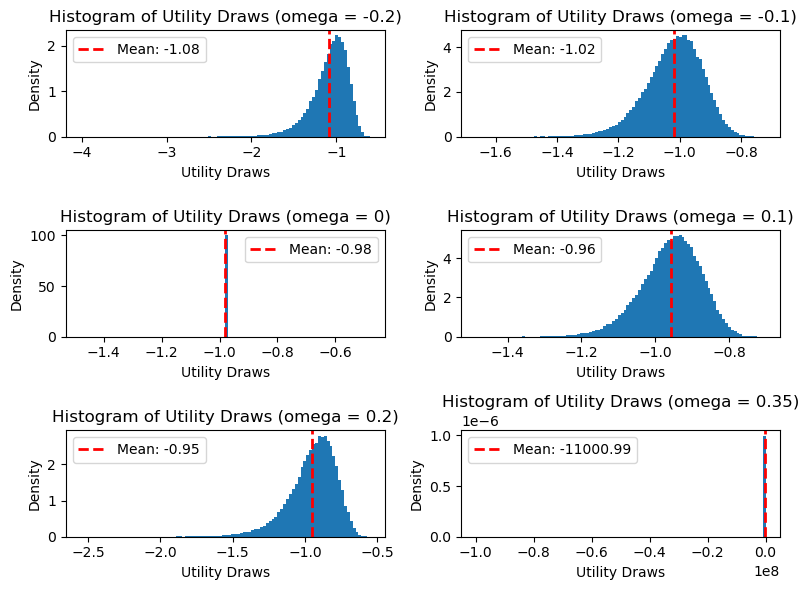

In [9]:
# Show utility distribution as function of portfolio share
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(8, 6))
axes_list = axes.flatten()

# Loop over omega values and corresponding subplot axes
for i, tmp_omega in enumerate([-0.2, -0.1, 0, 0.1, 0.2, 0.35]):
    # Calculate wealth distributions
    wealth_dist, util_dist, mc_results = MonteCarlo_int(
        omega=tmp_omega, N=int(1e5), ret_distributions=True
    )

    # Plot histogram on the corresponding subplot
    ax = axes_list[i]
    ax.hist(util_dist, bins=100, density=True)
    ax.axvline(mc_results, color='r', linestyle='dashed', linewidth=2,
               label=f'Mean: {mc_results:.2f}')
    ax.set_xlabel('Utility Draws')
    ax.set_ylabel('Density')
    ax.set_title(f'Histogram of Utility Draws (omega = {tmp_omega})')
    ax.legend()

plt.tight_layout()
plt.show()

## 2b) Optimal portfolio share via Monte Carlo integration

Using Monte Carlo integration, I estimate the optimal portfolio share to the risky asset to be 19.98\%, very similar to the analytical solution of 20.0\%. The linear approximation of marginal utility works well in this case because the MC integration only considers portfolio shares that do not create a substantial chance of wipeout, which would create large negative utility outcomes that dominate the expected utility calculation. Thus, based on the return distribution and risk-free rate, the optimal portfolio share is chosen to avoid large fluctuations in wealth, which is consistent with the assumptions underlying the linear approximation of marginal utility.

Optimal portfolio share via analytic: 19.98%
Optimal portfolio share via MC integration: 20.00%, with expected utility -0.9512


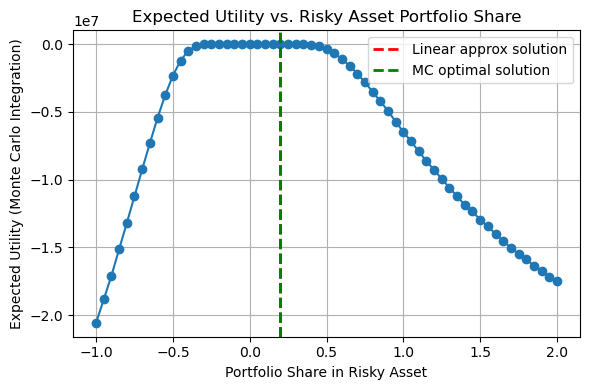

In [31]:
# Recall analytic solution
print(f'Optimal portfolio share via analytic: {port_share_analytic:.2%}')

# Estimate expected utility for range of portfolio shares
port_share_range = np.arange(-1, 2.05, 0.05)
expected_util_MC = []
for tmp_port_share in port_share_range:
    expected_util_MC.append(MonteCarlo_int(omega = tmp_port_share, N = 10**6))

# identify max expected utility and corresponding portfolio share
max_util = max(expected_util_MC)
opt_port_share = port_share_range[expected_util_MC.index(max_util)]
print(f'Optimal portfolio share via MC integration: {opt_port_share:.2%}, with expected utility {max_util:.4f}')

# Expected utility ~ f(portfolio share), line at optimal portfolio share
plt.figure(figsize=(6,4))
plt.plot(port_share_range, expected_util_MC, marker='o')
plt.axvline(port_share_analytic, color='r', linestyle='dashed', linewidth=2, label="Linear approx solution")
plt.axvline(opt_port_share, color='g', linestyle='dashed', linewidth=2, label="MC optimal solution")
plt.xlabel('Portfolio Share in Risky Asset')
plt.ylabel('Expected Utility (Monte Carlo Integration)')
plt.title('Expected Utility vs. Risky Asset Portfolio Share')
plt.grid(True);plt.tight_layout();plt.legend();plt.show()

### 2c) From this plot, can you see general conclusions about the willingness of the CRRA investor to hold short or levered positions in the risky asset?

Yes, the highly risk-averse CRRA investor with $\gamma = 2$ is strongly opposed to holding short or levered positions in the risky asset. The expected utility drops off sharply for portfolio shares less than -0.4 and greater than approximately 0.5. This suggests that the investor prefers to avoid the risky asset as to avoid scenarios with even a small probability of large negative wealth outcomes.

### 2d) MC integration involves numerical error. What is your informed guess about what the true distribution implies about the willingness of the CRRA investor to hold short or levered positions in the risky asset?

The true distribution should imply that the CRRA investor diametrically opposed to holding both short and levered positions in the risky asset for fear of wipeout. For example, my earlier estimation of wipeout probabilities via the CLT shows the probability of a wipeout with asset shares -1 and 2 are approximately equal at 17.9\% and 20.0\%, respectively. Thus, the true distribution should show that the expected utility at these portfolio shares are roughly equal, which is not perfectly captured in the previous plot due to numerical error.

### 3. MC integration with modified utility function

Assume investor has a subsistence level of wealth $S$ that they never want wealth to drop below under any circumstance, expressed through the utility function:
   $$U(W) = \frac{(W - S)^{1-\gamma}}{1-\gamma}$$
 defined only for $W\geq S$.

In [32]:
# Subsistence level utility function
def subsistence_utility(w, s, gamma):
    if gamma == 1:
        return np.log(w)  # avoid log(0)
    else:
        util_vec = (w - s) ** (1 - gamma) / (1 - gamma)
        return util_vec

In [33]:
# Estimate expected utility via Monte Carlo integration
gamma = 2 # relative risk aversion parameters
def MonteCarlo_int_subsistence(omega, sub_level, N, ret_distributions = False):
   # Draw N risky asset returns
   R_risky = np.random.normal(loc = mu_R, scale = np.sqrt(var_R), size = N) # standard dev, not variance
   wealth = omega * R_risky + (1-omega) * R_f
   wealth = np.clip(wealth, sub_level + 1e-8, None) # util func defined for W >= S

   # check distributions in MC simulation
   if ret_distributions:
       return wealth, subsistence_utility(wealth, sub_level, gamma), np.mean(subsistence_utility(wealth, sub_level, gamma))
   return np.mean(subsistence_utility(wealth, sub_level, gamma)) # average utility of wealth

## 3a. Subsistence level S = 0.3

Optimal portfolio share via MC integration (S=0.3): 15.00%, with expected utility -1.3483


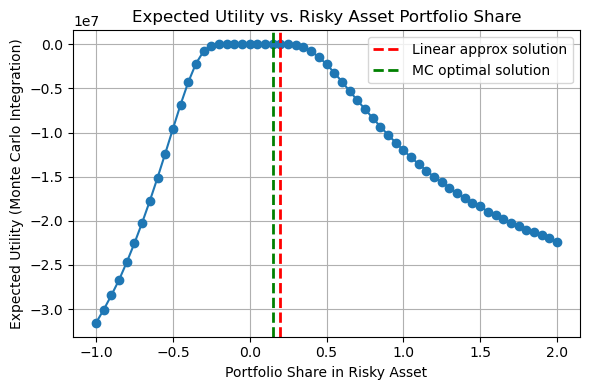

In [29]:
# plot distribution of utility(wealth) for select omega
tmp_omega, tmp_sub_level = 0, 0.3
# Estimate expected utility for range of portfolio shares
port_share_range = np.arange(-1, 2.05, 0.05)
expected_util_MC = []
for tmp_port_share in port_share_range:
    expected_util_MC.append(MonteCarlo_int_subsistence(omega = tmp_port_share, sub_level=tmp_sub_level, N = 10**6))

# identify max expected utility and corresponding portfolio share
max_util = max(expected_util_MC)
opt_port_share = port_share_range[expected_util_MC.index(max_util)]
print(f'Optimal portfolio share via MC integration (S=0.3): {opt_port_share:.2%}, with expected utility {max_util:.4f}')

# Expected utility ~ f(portfolio share)
plt.figure(figsize=(6,4))
plt.plot(port_share_range, expected_util_MC, marker='o')
plt.axvline(port_share_analytic, color='r', linestyle='dashed', linewidth=2, label="Linear approx solution")
plt.axvline(opt_port_share, color='g', linestyle='dashed', linewidth=2, label="MC optimal solution")
plt.xlabel('Portfolio Share in Risky Asset')
plt.ylabel('Expected Utility (Monte Carlo Integration)')
plt.title('Expected Utility vs. Risky Asset Portfolio Share')
plt.grid(True);plt.tight_layout();plt.legend();plt.show()

## 3b. Subsistence level S = 0.5

Optimal portfolio share via MC integration (S=0.5): 10.00%, with expected utility -1.8665


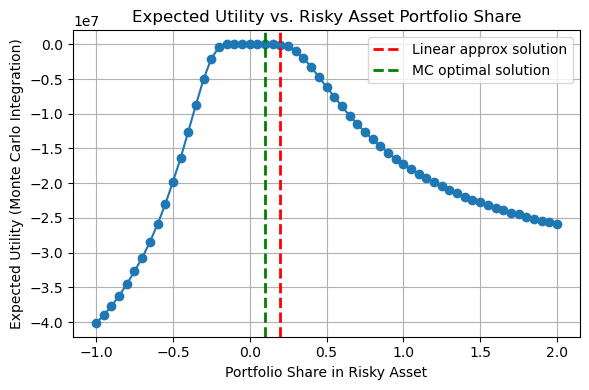

In [30]:
# plot distribution of utility(wealth) for select omega
tmp_omega, tmp_sub_level = 0, 0.5
# Estimate expected utility for range of portfolio shares
port_share_range = np.arange(-1, 2.05, 0.05)
expected_util_MC = []
for tmp_port_share in port_share_range:
    expected_util_MC.append(MonteCarlo_int_subsistence(omega = tmp_port_share, sub_level=tmp_sub_level, N = 10**6))

# identify max expected utility and corresponding portfolio share
max_util = max(expected_util_MC)
opt_port_share = port_share_range[expected_util_MC.index(max_util)]
print(f'Optimal portfolio share via MC integration (S=0.5): {opt_port_share:.2%}, with expected utility {max_util:.4f}')

# Expected utility ~ f(portfolio share)
plt.figure(figsize=(6,4))
plt.plot(port_share_range, expected_util_MC, marker='o')
plt.axvline(port_share_analytic, color='r', linestyle='dashed', linewidth=2, label="Linear approx solution")
plt.axvline(opt_port_share, color='g', linestyle='dashed', linewidth=2, label="MC optimal solution")
plt.xlabel('Portfolio Share in Risky Asset')
plt.ylabel('Expected Utility (Monte Carlo Integration)')
plt.title('Expected Utility vs. Risky Asset Portfolio Share')
plt.grid(True);plt.tight_layout();plt.legend();plt.show()

### 3c) How does the subsistence level affect the optimal portfolio share?

The subsistence level has a significant impact on the optimal portfolio share. As the subsistence level increases from 0.3 to 0.5, the optimal portfolio share decreases from approximately 15.00\% to 10.00\%. This indicates that as the investor's minimum acceptable wealth level rises, they become more risk-averse and under CRRA preferences, allocate less to the risky asset to avoid a wealth wipeout, now occuring at a higher level of wealth. Thus, the higher subsistence level effectively raises the threshold for acceptable outcomes, making the investor more cautious in their investment strategy and reducing their exposure to risk.